# Credit Card Fraud Detection
Anonymized credit card transactions labeled as fraudulent or genuine

Kaggle project hosted on https://www.kaggle.com/dalpozz/creditcardfraud

The datasets contains transactions made by credit cards in September 2013 by european cardholders. 
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise. 

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

The dataset has been collected and analysed during a  research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection.
More details on current and past projects on related topics are available on http://mlg.ulb.ac.be/BruFence and http://mlg.ulb.ac.be/ARTML

Please cite: Andrea Dal Pozzolo, Olivier Caelen, Reid A. Johnson and Gianluca Bontempi. Calibrating Probability with Undersampling for Unbalanced Classification. In Symposium on Computational Intelligence and Data Mining (CIDM), IEEE, 2015

# Setting up
Import relevant packages and read dataset.

In [429]:
import pylab as py
import pandas as pd
import seaborn as sns
import sklearn.linear_model
import sklearn.metrics
import sklearn.model_selection
import sklearn.svm
import sklearn.naive_bayes
import sklearn.tree

%matplotlib notebook

In [430]:
dataset_filename = 'creditcard.csv'
dataset = pd.read_csv(dataset_filename)

In [431]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

# Checking data
It is said that features V1 to V28 are uncorrelated. I can check that this is true.

In [432]:
pca_which = [x[0]=='V' for x in dataset.columns]
covariance_matrix = dataset.cov()
covariance_pca = covariance_matrix.loc[pca_which,pca_which]
off_diagonal = covariance_pca - py.diag(py.diag(covariance_pca))
print('Maximum off-diagonal correlation coefficient is ',max(abs(off_diagonal.values.flatten())))

Maximum off-diagonal correlation coefficient is  2.27474416705e-14


Each PCA variable explain part of the variance observed in the dataset. I will now check the relative importance of each variable.

In [433]:
%matplotlib notebook

<IPython.core.display.Javascript object>


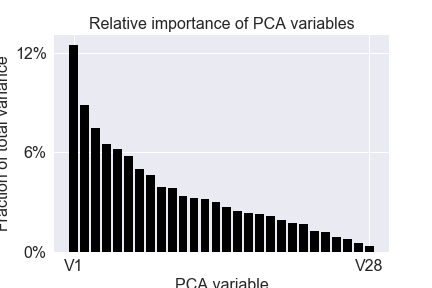

In [434]:
fig = py.figure()
ax = fig.add_subplot(111)
variances = py.diag(covariance_pca)
total_variance = sum(variances)
ax.bar(range(len(variances)),variances/total_variance,width=0.8,color='k')
ax.set_xticks([0,27])
ax.set_xticklabels(['V1','V28'],fontsize=16)
ax.set_xlabel('PCA variable',fontsize=16)
ax.set_yticks([0,0.06,0.12])
ax.set_yticklabels(['0%','6%','12%'],fontsize=16)
ax.set_ylabel('Fraction of total variance',fontsize=16)
ax.set_title('Relative importance of PCA variables',fontsize=16);

The first (most important) PCA variable explains about 12.5% of the variance in data, while the last (least important) variable explains about 0.3% of the variance in data. This does not justify discarding any of the variables.

# Which variables are highly correlated with fraud?
We can consider the strenght of correlation of each variable with the variable we are trying to predict.

<IPython.core.display.Javascript object>


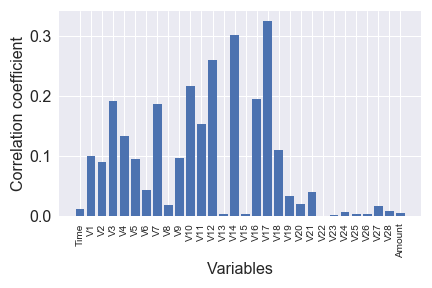

In [437]:
correlation_matrix = dataset.corr()
correlation_var = correlation_matrix.loc['Class',[x for x in correlation_matrix.columns if x!='Class']]
fig = py.figure()
ax = fig.add_subplot(111)
ax.bar(range(len(correlation_var)),abs(correlation_var),width=0.8)
ax.set_xticks(range(len(correlation_var)))
ax.set_xticklabels(correlation_var.index,rotation='vertical')
ax.set_xlabel('Variables',fontsize=16)
ax.set_ylabel('Correlation coefficient',fontsize=16)
ax.set_yticks([0,0.1,0.2,0.3])
ax.set_yticklabels([str(x) for x in ax.get_yticks()],fontsize=16);
fig.tight_layout()

Some variables are highly correlated with the variable to predict. This is good news.

# Data visualization
Since the data is already in PCA form, I can visualize them two-at-a-time.

In [438]:
def Data_Visualization(dataset,variableX,variableY,equal=True):
    dataset_valid = dataset[dataset['Class']==0]
    dataset_fraud = dataset[dataset['Class']==1]
    data_x_valid = dataset_valid[variableX]
    data_y_valid = dataset_valid[variableY]
    data_x_fraud = dataset_fraud[variableX]
    data_y_fraud = dataset_fraud[variableY]
    fig = py.figure()
    if equal:
        ax = fig.add_subplot(111,aspect='equal')
    else:
        ax = fig.add_subplot(111)
    ax.scatter(data_x_valid,data_y_valid,marker='.',color='k',label='Valid')
    ax.scatter(data_x_fraud,data_y_fraud,marker='*',color='r',label='Fraud')
    ax.set_xlabel(variableX,fontsize=16)
    ax.set_ylabel(variableY,fontsize=16)
    return fig,ax

<IPython.core.display.Javascript object>


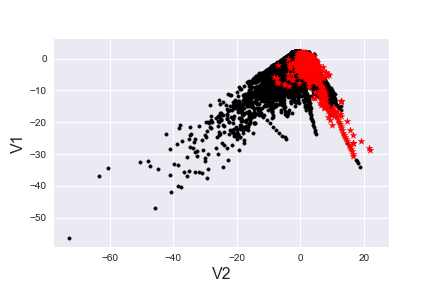

In [439]:
fig,ax = Data_Visualization(dataset,'V2','V1')

<IPython.core.display.Javascript object>


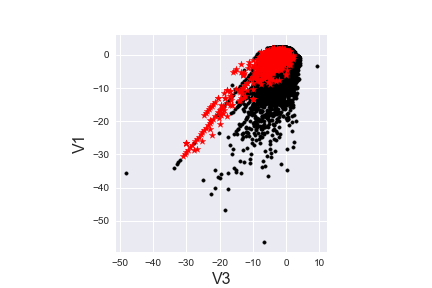

In [440]:
fig,ax = Data_Visualization(dataset,'V3','V1')

<IPython.core.display.Javascript object>


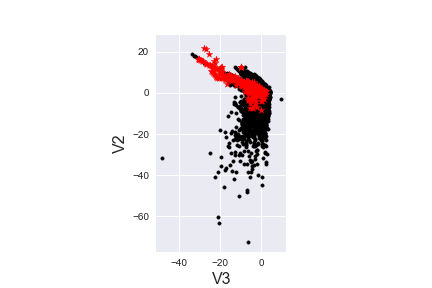

In [441]:
fig,ax = Data_Visualization(dataset,'V3','V2')

These plots are promising. It shows that the fraudulent transactions are concentrated and we can hope to find a rule that can separate them from the valid transactions. At the very least, we see that a simple model using only V1-V2-V3 can already flag many transactions as very likely to be non-fraudulent.

Variables V14 and V17 showed high correlation with the class variable.

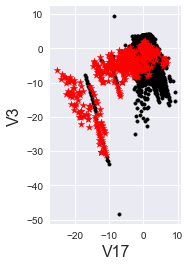

In [230]:
fig,ax = Data_Visualization(dataset,'V17','V3')

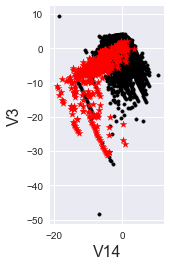

In [231]:
fig,ax = Data_Visualization(dataset,'V14','V3')

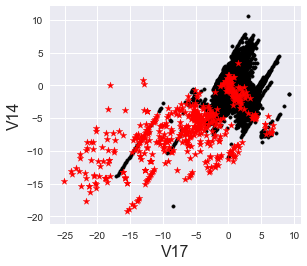

In [232]:
fig,ax = Data_Visualization(dataset,'V17','V14')

# Dealing with time
The data includes two day's worth of transactions, labeled by seconds after the first transaction, which we don't know when it happened. From a histogram, we can infer that this transaction happened in the middle of the night, possibly at midnight of the relevant timezone.

In [233]:
dataset['Time_hours']  = dataset['Time'].apply(lambda x: x/(3600.))
print('Maximum of time variable is {:5.2f} hours'.format(max(dataset['Time_hours'])))

Maximum of time variable is 48.00 hours


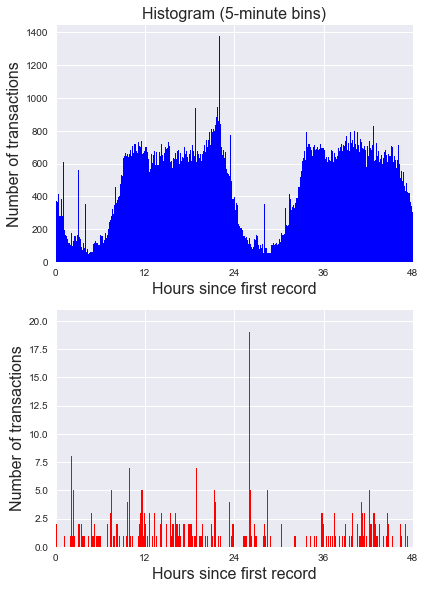

In [234]:
fig = py.figure(figsize=(1*6.4,2*4.8))
ax = fig.add_subplot(211)
n_bins = 48*12
hist_all_y,hist_all_x,_ = ax.hist(dataset[dataset['Class']==0]['Time_hours'],bins=n_bins,color='b',normed=None,range=(0,48));
ax.set_xlabel('Hours since first record',fontsize=16)
ax.set_ylabel('Number of transactions',fontsize=16);
ax.set_title('Histogram (5-minute bins)',fontsize=16)
ax.set_xticks([0,12,24,36,48])
ax.set_xlim([0,48]);
ax = fig.add_subplot(212)
hist_fraud_y,hist_fraud_x,_ = ax.hist(dataset[dataset['Class']==1]['Time_hours'],bins=n_bins,color='r',normed=None,range=(0,48));
ax.set_xlabel('Hours since first record',fontsize=16)
ax.set_ylabel('Number of transactions',fontsize=16);
ax.set_xticks([0,12,24,36,48])
ax.set_xlim([0,48]);

The histogram for all transactions show a clear pattern of day-night, even that the information is not fully present in the dataset. The histogram for fraudulent transactions, on the other hand, do not show quite the same pattern. This can be due to two reasons. One is that the sample size is small, only 500 fraudulent transactions. Another is that the frauds really do not obey the same day-night cycle as the legitimate transactions.

## Fourier variables

The influence of the transaction time on the probability of fraud has to be periodic with a period of 24 hours. Other cycles could be possible, such as a seven-day cycle to account for different weekday/weekend patterns, and possibly holidays. However, with only two days of data available, these cycles can not be studied. Because of that, I will consider, instead of the variable time, a set of Fourier coefficients for each transaction.

To check how many harmonics must be included, one can fit the time histogram with some number of harmonics.


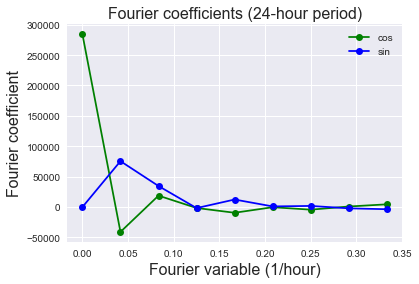

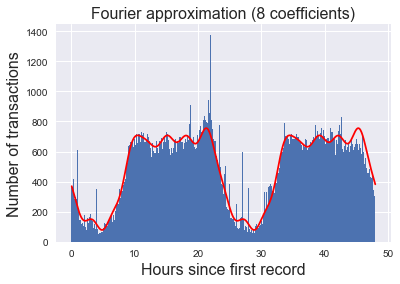

In [235]:
fourier_transform = py.rfft(hist_all_y)
n_coefficients = min(17,len(fourier_transform))

fig = py.figure()
ax = fig.add_subplot(111)
xx = py.rfftfreq(len(hist_all_y),48./len(hist_all_y))
ax.plot(xx[0:n_coefficients:2],py.real(fourier_transform)[0:n_coefficients:2],'go-',label='cos')
ax.plot(xx[0:n_coefficients:2],py.imag(fourier_transform)[0:n_coefficients:2],'bo-',label='sin')
ax.legend()
# ax.plot(xx[1:n_coefficients:2],abs(fourier_transform)[1:n_coefficients:2],'ro-')
ax.set_yscale('linear')
ax.set_xscale('linear')
ax.set_xlabel('Fourier variable (1/hour)',fontsize=16)
ax.set_ylabel('Fourier coefficient',fontsize=16)
ax.set_title('Fourier coefficients (24-hour period)',fontsize=16)

fig = py.figure()
ax = fig.add_subplot(111)
width = hist_all_x[1] - hist_all_x[0]
ax.bar(hist_all_x[:-1],hist_all_y,width=width)
fft = py.rfft(hist_all_y)
size = len(hist_all_y)
period = 48
reconstructed = py.array([fft[0].real / size for x in hist_all_x[1:]])
# n_coefficients = 48
for harmonics in range(2,min(len(fft),n_coefficients),2):
    reconstructed += py.array([fft[harmonics].real*py.cos(+harmonics * 2*py.pi*x/period)*2/size for x in hist_all_x[1:]])
    reconstructed += py.array([fft[harmonics].imag*py.sin(-harmonics * 2*py.pi*x/period)*2/size for x in hist_all_x[1:]])
ax.plot(hist_all_x[1:],reconstructed,'r-')
ax.set_xlabel('Hours since first record',fontsize=16)
ax.set_ylabel('Number of transactions',fontsize=16);
ax.set_title('Fourier approximation ({:d} coefficients)'.format(int(n_coefficients/2)),fontsize=16)




I will then add features that correspond to these harmonics (which tracks changes in a three-hour timescale)

In [236]:
# Creating Fourier variables with daily frequency
for column in dataset.columns:
    if 'Time_Fourier_Day' in column:
        dataset.drop(column,axis=1,inplace=True)
n_harmonics = 8
period = 24 * 60 * 60.0
for harmonic in range(1,1+n_harmonics):
    dataset['Time_Fourier_Day_C{:02d}'.format(harmonic)] = dataset['Time'].apply(lambda x,h=harmonic:py.cos(h*2*py.pi*x/period))
    dataset['Time_Fourier_Day_S{:02d}'.format(harmonic)] = dataset['Time'].apply(lambda x,h=harmonic:py.sin(h*2*py.pi*x/period))

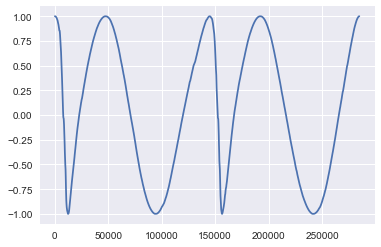

In [237]:
fig,ax = py.subplots()
ax.plot( dataset['Time_Fourier_Day_C02'])

In [288]:
### By hand doing a probability of sucess 
fraction_of_frauds = [(t,y/x,py.sqrt(y)/x) if x!=0 else (t,py.nan) for x,y,t in zip(hist_all_y,hist_fraud_y,hist_all_x)]

<Container object of 3 artists>

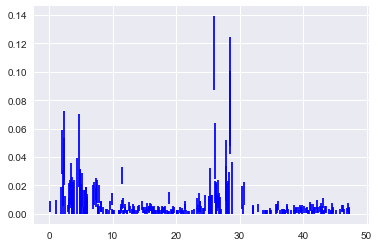

In [289]:
fig = py.figure()
ax = fig.add_subplot(111)
fraction_of_frauds = py.array(fraction_of_frauds).T
ax.errorbar(fraction_of_frauds[0],fraction_of_frauds[1],yerr=fraction_of_frauds[2],fmt='bx')

In [290]:
help(py.rfft)

Help on function rfft in module numpy.fft.fftpack:

rfft(a, n=None, axis=-1, norm=None)
    Compute the one-dimensional discrete Fourier Transform for real input.
    
    This function computes the one-dimensional *n*-point discrete Fourier
    Transform (DFT) of a real-valued array by means of an efficient algorithm
    called the Fast Fourier Transform (FFT).
    
    Parameters
    ----------
    a : array_like
        Input array
    n : int, optional
        Number of points along transformation axis in the input to use.
        If `n` is smaller than the length of the input, the input is cropped.
        If it is larger, the input is padded with zeros. If `n` is not given,
        the length of the input along the axis specified by `axis` is used.
    axis : int, optional
        Axis over which to compute the FFT. If not given, the last axis is
        used.
    norm : {None, "ortho"}, optional
        .. versionadded:: 1.10.0
    
        Normalization mode (see `numpy.fft`). 

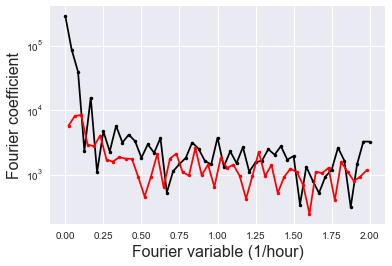

In [370]:
fft = py.rfft(hist_all_y)
fig,ax = py.subplots()
xx = py.rfftfreq(len(hist_all_y),48./len(hist_all_y))
# ax.plot(fft.real[0:],'bo-')
# ax.plot(fft.imag[0:],'ro-')
maxxx = min(97,len(fft))
ax.plot(xx[0:maxxx:2],abs(fft)[0:maxxx:2],'k.-')
ax.plot(xx[1:maxxx:2],abs(fft)[1:maxxx:2],'r.-')
ax.set_yscale('log')
ax.set_xscale('linear')
ax.set_xlabel('Fourier variable (1/hour)',fontsize=16)
ax.set_ylabel('Fourier coefficient',fontsize=16)

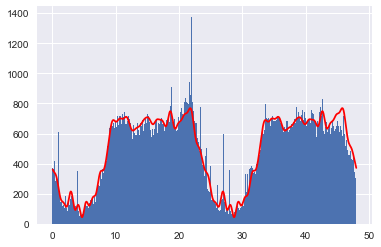

In [359]:
fig = py.figure()
ax = fig.add_subplot(111)
width = hist_all_x[1] - hist_all_x[0]
ax.bar(hist_all_x[:-1],hist_all_y,width=width)
fft = py.rfft(hist_all_y)
size = len(hist_all_y)
period = 48
reconstructed = py.array([fft[0].real / size for x in hist_all_x[1:]])
for harmonics in range(2,min(len(fft),48),2):
    reconstructed += py.array([fft[harmonics].real*py.cos(+harmonics * 2*py.pi*x/period)*2/size for x in hist_all_x[1:]])
    reconstructed += py.array([fft[harmonics].imag*py.sin(-harmonics * 2*py.pi*x/period)*2/size for x in hist_all_x[1:]])
ax.plot(hist_all_x[1:],reconstructed,'r-')



In [371]:
help(py.fft)

Help on function fft in module numpy.fft.fftpack:

fft(a, n=None, axis=-1, norm=None)
    Compute the one-dimensional discrete Fourier Transform.
    
    This function computes the one-dimensional *n*-point discrete Fourier
    Transform (DFT) with the efficient Fast Fourier Transform (FFT)
    algorithm [CT].
    
    Parameters
    ----------
    a : array_like
        Input array, can be complex.
    n : int, optional
        Length of the transformed axis of the output.
        If `n` is smaller than the length of the input, the input is cropped.
        If it is larger, the input is padded with zeros.  If `n` is not given,
        the length of the input along the axis specified by `axis` is used.
    axis : int, optional
        Axis over which to compute the FFT.  If not given, the last axis is
        used.
    norm : {None, "ortho"}, optional
        .. versionadded:: 1.10.0
    
        Normalization mode (see `numpy.fft`). Default is None.
    
    Returns
    -------
    o

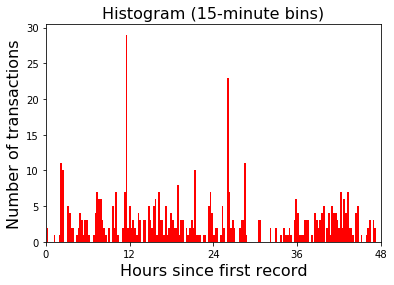

In [228]:
fig = py.figure()
ax = fig.add_subplot(111)
ax.hist(dataset[dataset['Class']==1]['Time_hours'],bins=48*4,color='r',normed=None);
ax.set_xlabel('Hours since first record',fontsize=16)
ax.set_ylabel('Number of transactions',fontsize=16);
ax.set_title('Histogram (15-minute bins)',fontsize=16)
ax.set_xticks([0,12,24,36,48])
ax.set_xlim([0,48]);

In [373]:
# Creating Fourier variables with daily frequency
for column in dataset.columns:
    if 'Time_Fourier_Day' in column:
        dataset.drop(column,axis=1,inplace=True)
n_harmonics = 4
period = 24 * 60 * 60.0
for harmonic in range(1,1+n_harmonics):
    dataset['Time_Fourier_Day_C'+str(harmonic)] = dataset['Time'].apply(lambda x,h=harmonic:py.cos(h*x/period))
    dataset['Time_Fourier_Day_S'+str(harmonic)] = dataset['Time'].apply(lambda x,h=harmonic:py.sin(h*x/period))

KeyError: 'Time_hour'

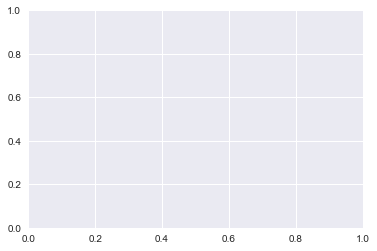

In [375]:
fig,ax = py.subplots()
for harmonic in range(1,1+n_harmonics):
    ax.plot(dataset['Time_hour'],dataset['Time_Fourier_Day_C'+str(harmonic)])
    ax.plot(dataset['Time_hour'],dataset['Time_Fourier_Day_S'+str(harmonic)])

# View transaction amout
Like many money variables (that are constrained to be positive), the distribution of this variable is highly skewed with a long right tail. Because of that, it's best to consider the logarithm of the value.

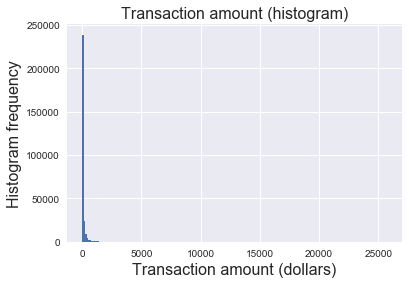

In [355]:
fig = py.figure()
ax = fig.add_subplot(111)
data_y = dataset['Amount']
ax.hist(data_y,bins=200);
ax.set_xlabel('Transaction amount (dollars)',fontsize=16)
ax.set_ylabel('Histogram frequency',fontsize=16)
ax.set_title('Transaction amount (histogram)',fontsize=16)

In [239]:
value_for_zero = py.log10(1e-3)
dataset['Amount_log'] = dataset['Amount'].apply(lambda x:py.log10(x) if x>0 else value_for_zero)

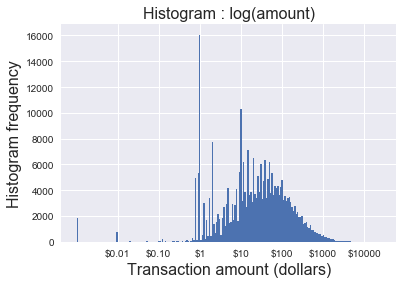

In [240]:
fig = py.figure()
ax = fig.add_subplot(111)
amount_log = py.array([x for x in dataset['Amount_log'] if not py.isnan(x)])
histogram_y,histogram_x,patches = ax.hist(amount_log,bins='auto');
ax.set_xlabel('Transaction amount (dollars)',fontsize=16)
ax.set_ylabel('Histogram frequency',fontsize=16)
ax.set_title('Histogram : log(amount)',fontsize=16);
ax.set_xticks(range(-2,5))
ax.set_xticklabels(['${:d}'.format(int(10.**x)) if x>=0 else '${:.02f}'.format(10.**x) for x in ax.get_xticks()])

This histogram follows a Gaussian envelope with some spikes. To understand these spikes, it's instructive to look at the histogram of the cents part of the amount.

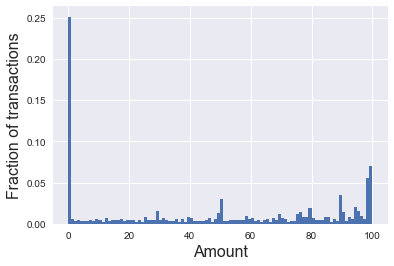

In [241]:
dataset['Amount_dollars'] = dataset['Amount'].apply(lambda x:int(x))
dataset['Amount_cents'] = dataset['Amount'].apply(lambda x:int(100*(x-int(x))))
fig = py.figure()
ax = fig.add_subplot(111)
hist_y,hist_x,_ = ax.hist(dataset['Amount_cents'],bins=100,range=(0,100),normed=1);
ax.set_xlabel('Amount',fontsize=16)
ax.set_ylabel('Fraction of transactions',fontsize=16)

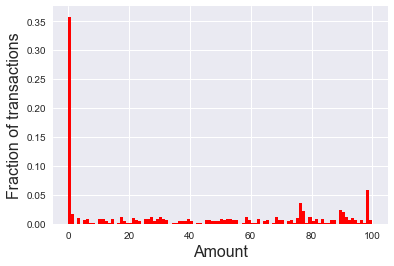

In [242]:
fig = py.figure()
ax = fig.add_subplot(111)
hist_y,hist_x,_ = ax.hist(dataset[dataset['Class']==1]['Amount_cents'],bins=100,range=(0,100),normed=1,color='r');
ax.set_xlabel('Amount',fontsize=16)
ax.set_ylabel('Fraction of transactions',fontsize=16)

Most transactions involve a whole-dollar amount. There is also some smaller peaks at almost-dollar (values ending in 0.90, 0.98 or 0.99) and also at 0.50. Then, I will create categorical variables to account for these conditions.

In [243]:
def categorizeCents(cents):
    if cents in [0]:
        return 'WholeDollar'
    elif cents in [50]:
        return 'HalfDollar'
    elif cents in [90,98,99]:
        return 'AlmostDollar'
    else:
        return 'Other'
dataset['Amount_centsCategory'] = dataset['Amount_cents'].apply(categorizeCents)

In [244]:
dataset['Amount_centsCategory'].value_counts()

Other           164555
WholeDollar      71516
AlmostDollar     40091
HalfDollar        8645
Name: Amount_centsCategory, dtype: int64

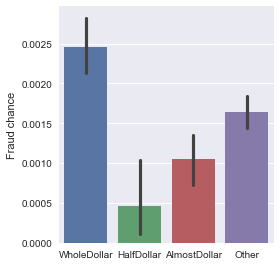

In [245]:
order = ['WholeDollar','HalfDollar','AlmostDollar','Other']
ax = sns.factorplot(x='Amount_centsCategory',y='Class',data=dataset,kind='bar',order=order)
ax.set_axis_labels('','Fraud chance')

Transactions with a whole amount of dollars seem to be more likely to be fraudulent than others.

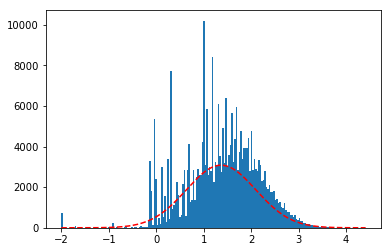

In [168]:
fig = py.figure()
ax = fig.add_subplot(111)
amount_log = py.array([x for x in dataset['Amount_log'] if not py.isnan(x) and x!=0])
histogram_y,histogram_x,patches = ax.hist(amount_log,bins='auto')
nonzeros = py.array([(x,y) for x,y in zip(histogram_x,histogram_y) if y>0])
poly_fitting = py.polyfit(nonzeros.T[0],py.log(nonzeros.T[1]),2)
histogram_y_fitted = py.exp(py.polyval(poly_fitting,histogram_x))
ax.plot(histogram_x,histogram_y_fitted,'r--')
ax.set_yscale('linear')

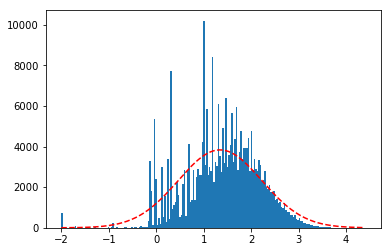

In [171]:
fig = py.figure()
ax = fig.add_subplot(111)
amount_log = py.array([x for x in dataset['Amount_log'] if not py.isnan(x) and x!=0])
histogram_y,histogram_x,patches = ax.hist(amount_log,bins='auto')
amount_log_mean = amount_log.mean()
amount_log_median = py.log10(dataset['Amount'].median())
amount_log_std = amount_log.std()
histogram_y_fitted = py.array(list(map(lambda x:py.exp(-(x-amount_log_median)**2/(2*amount_log_std)),histogram_x[:-1])))
histogram_y_fitted = histogram_y_fitted * sum(histogram_y) / sum(histogram_y_fitted)
ax.plot(histogram_x[:-1],histogram_y_fitted,'r--')
ax.set_yscale('linear')

In [172]:
amount_log_mean,amount_log_std

(1.3714540131920481, 0.77596004623853609)

In [156]:
10**(histogram_x[1+list(histogram_y).index(max(histogram_y))])

1.0021616353487719

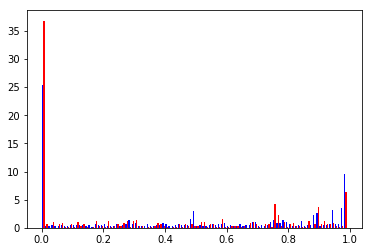

In [185]:
fig = py.figure()
ax = fig.add_subplot(111)
data_y = []
data_y.append([x%1 for x in dataset[dataset['Class']==0]['Amount']])
data_y.append([x%1 for x in dataset[dataset['Class']==1]['Amount']])
ax.hist(data_y,bins=99,color=['b','r'],normed=1);
# ax.hist([x%1 for x in dataset[dataset['Class']==1]['Amount']],bins=99,color='r',normed=True);

In [162]:
dataset['Amount'].median()

22.0

# Feature selection

In [246]:
features_pca = dataset[[x for x in dataset.columns if x[0]=='V']]
features_amount_cents = pd.get_dummies(dataset['Amount_centsCategory'],prefix='Amount_cents')
features_amount_cents = features_amount_cents.drop('Amount_cents_Other',axis=1)
features_amount = dataset[['Amount_log']]
features_time = dataset[[x for x in dataset.columns if 'Time_Fourier_Day' in x]]
features_label = dataset[['Class']]

In [247]:
datasets_selected = [features_pca,features_amount_cents,features_amount,features_time,features_label]
dataset_selected = datasets_selected[0]
for ds in datasets_selected[1:]:
    dataset_selected = dataset_selected.join(ds)

In [248]:
dataset_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 49 columns):
V1                           284807 non-null float64
V2                           284807 non-null float64
V3                           284807 non-null float64
V4                           284807 non-null float64
V5                           284807 non-null float64
V6                           284807 non-null float64
V7                           284807 non-null float64
V8                           284807 non-null float64
V9                           284807 non-null float64
V10                          284807 non-null float64
V11                          284807 non-null float64
V12                          284807 non-null float64
V13                          284807 non-null float64
V14                          284807 non-null float64
V15                          284807 non-null float64
V16                          284807 non-null float64
V17                          284807 non-n

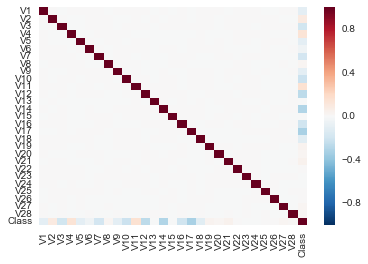

In [249]:
corr = features_pca.join(features_label).corr()
sns.heatmap(corr,xticklabels=True,yticklabels=True,vmax=1,vmin=-1)

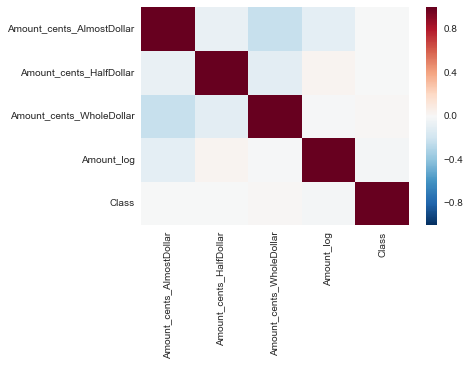

In [250]:
corr = features_amount_cents.join(features_amount).join(features_label).corr()
sns.heatmap(corr,xticklabels=True,yticklabels=True,vmax=1,vmin=-1)

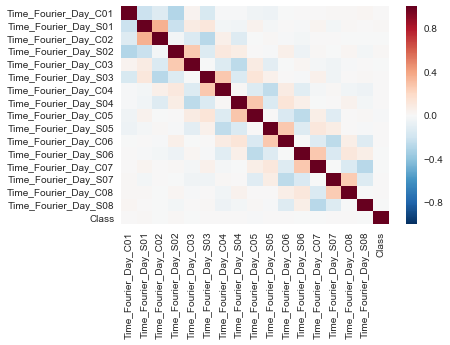

In [251]:
corr = features_time.join(features_label).corr()
sns.heatmap(corr,xticklabels=True,yticklabels=True,vmax=1,vmin=-1)

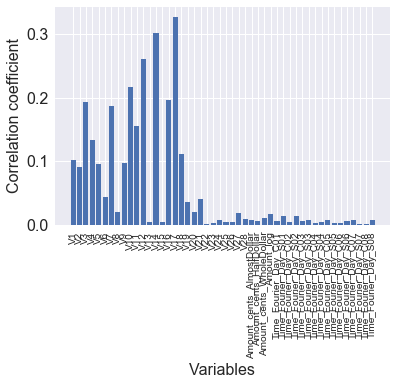

In [252]:
correlation_matrix = dataset_selected.corr()
correlation_var = correlation_matrix.loc['Class',[x for x in correlation_matrix.columns if x!='Class']]
fig = py.figure()
ax = fig.add_subplot(111)
ax.bar(range(len(correlation_var)),abs(correlation_var),width=0.8)
ax.set_xticks(range(len(correlation_var)))
ax.set_xticklabels(correlation_var.index,rotation='vertical')
ax.set_xlabel('Variables',fontsize=16)
ax.set_ylabel('Correlation coefficient',fontsize=16)
ax.set_yticks([0,0.1,0.2,0.3])
ax.set_yticklabels([str(x) for x in ax.get_yticks()],fontsize=16);

# Creating a train and test set
To avoid problems with overfitting, it's important to test a model in a different dataset than it was trained on.

In [253]:
dataset_train,dataset_test = sklearn.model_selection.train_test_split(dataset_selected,test_size=0.2,random_state=0)
features_train = dataset_train.drop('Class',axis=1)
features_test = dataset_test.drop('Class',axis=1)
class_train = dataset_train['Class']
class_test = dataset_test['Class']

# A simple model - logistic regression

Before trying more 'fancy' models, I will look at a simple logistic regression, to serve as a benchmark. A simpler model of the logistic regression will actually only use the PCA variables.

In [344]:
estimator = sklearn.linear_model.LogisticRegression()
parameters = {'C':10**(py.linspace(-3,3,10))}
scoring = 'average_precision'
grid = sklearn.model_selection.GridSearchCV(estimator,parameters,scoring)
columns_pca = [x for x in features_train.columns if x[0]=='V']
grid.fit(features_train[columns_pca],class_train)
model_logreg_pca = grid.best_estimator_

In [345]:
model_logreg_pca

LogisticRegression(C=0.10000000000000001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

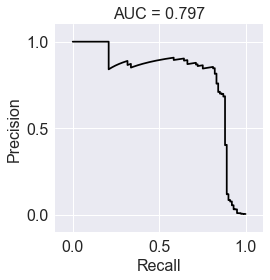

In [362]:
proba = model_logreg_pca.predict_proba(features_test[columns_pca])
precision_pca,recall_pca,threshold_pca = sklearn.metrics.precision_recall_curve(class_test,proba.T[1])
metric_pca = sklearn.metrics.average_precision_score(class_test,proba.T[1])
prc_logreg_pca = py.array([(x,y,z) for x,y,z in zip(precision_pca,recall_pca,threshold_pca)]).T
fig = py.figure()
ax = fig.add_subplot(111,aspect='equal')
ax.plot(recall_pca,precision_pca,'k-')
ax.set_xlim(-0.1,1.1)
ax.set_ylim(-0.1,1.1)
ax.set_xticks([0,0.5,1.0])
ax.set_xticklabels([str(x) for x in ax.get_xticks()],fontsize=16)
ax.set_yticks([0,0.5,1.0])
ax.set_yticklabels([str(x) for x in ax.get_xticks()],fontsize=16)
ax.set_xlabel('Recall',fontsize=16)
ax.set_ylabel('Precision',fontsize=16)
ax.set_title('AUC = {:5.3f}'.format(metric_pca),fontsize=16);
fig.tight_layout()

In [347]:
estimator = sklearn.linear_model.LogisticRegression()
parameters = {'C':10**(py.linspace(-3,3,10))}
scoring = 'average_precision'
grid = sklearn.model_selection.GridSearchCV(estimator,parameters,scoring)
columns_all = [x for x in features_train.columns]
grid.fit(features_train[columns_all],class_train)
model_logreg_all = grid.best_estimator_

# model_logreg_all = sklearn.linear_model.LogisticRegression()
# columns_all = [x for x in features_train.columns]
# model_logreg_all.fit(features_train[columns_all],class_train)

In [348]:
model_logreg_all

LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

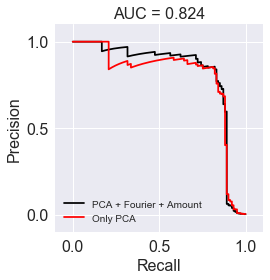

In [361]:
proba = model_logreg_all.predict_proba(features_test[columns_all])
precision_all,recall_all,threshold_all = sklearn.metrics.precision_recall_curve(class_test,proba.T[1])
metric = sklearn.metrics.average_precision_score(class_test,proba.T[1])
prc_logreg_all = py.array([(x,y,z) for x,y,z in zip(precision_all,recall_all,threshold_all)]).T
fig = py.figure()
ax = fig.add_subplot(111,aspect='equal')
ax.plot(recall_all,precision_all,'k-',label='PCA + Fourier + Amount')
ax.plot(recall_pca,precision_pca,'r-',label='Only PCA')
ax.set_xlim(-0.1,1.1)
ax.set_ylim(-0.1,1.1)
ax.set_xticks([0,0.5,1.0])
ax.set_xticklabels([str(x) for x in ax.get_xticks()],fontsize=16)
ax.set_yticks([0,0.5,1.0])
ax.set_yticklabels([str(x) for x in ax.get_xticks()],fontsize=16)
ax.set_xlabel('Recall',fontsize=16)
ax.set_ylabel('Precision',fontsize=16)
ax.set_title('AUC = {:5.3f}'.format(metric),fontsize=16);
ax.legend(loc='lower left')
fig.tight_layout()

Optimal F1 score : 0.834


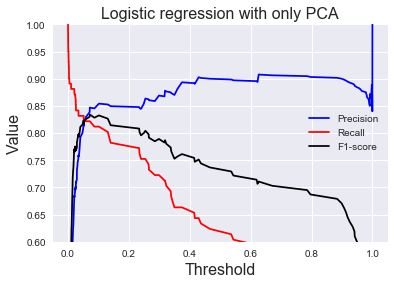

In [350]:
prt = py.array([(x,y,z) for x,y,z in zip(precision_pca,recall_pca,threshold_pca) if z>0.00 and z<1])
fig = py.figure()
ax = fig.add_subplot(111)
ax.plot(prt.T[2],prt.T[0],'b-',label='Precision')
ax.plot(prt.T[2],prt.T[1],'r-',label='Recall')
f1 = [(2*x[0]*x[1]/(x[0]+x[1])) for x in prt]
ax.plot(prt.T[2],f1,'k-',label='F1-score')
ax.set_xlabel('Threshold',fontsize=16)
ax.set_ylabel('Value',fontsize=16)
ax.set_title('Logistic regression with only PCA',fontsize=16)
ax.legend(loc='center right')
ax.set_ylim(0.6,1.0)
print('Optimal F1 score : {:5.3f}'.format(max(f1)))

Optimal F1 score : 0.838


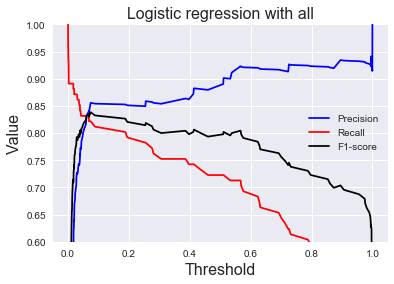

In [351]:
prt = py.array([(x,y,z) for x,y,z in zip(precision_all,recall_all,threshold_all) if z>0.00 and z<1])
fig = py.figure()
ax = fig.add_subplot(111)
ax.plot(prt.T[2],prt.T[0],'b-',label='Precision')
ax.plot(prt.T[2],prt.T[1],'r-',label='Recall')
f1 = [(2*x[0]*x[1]/(x[0]+x[1])) for x in prt]
ax.plot(prt.T[2],f1,'k-',label='F1-score')
ax.set_xlabel('Threshold',fontsize=16)
ax.set_ylabel('Value',fontsize=16)
ax.set_title('Logistic regression with all',fontsize=16)
ax.legend(loc='center right')
ax.set_ylim(0.6,1.0)
print('Optimal F1 score : {:5.3f}'.format(max(f1)))

In [302]:
model_logreg_all.intercept_[0]

-8.2099115404796468

In [309]:
confusion_logreg_pca = sklearn.metrics.confusion_matrix(class_test,model_logreg_pca.predict(features_test[columns_pca]))
confusion_logreg_all = sklearn.metrics.confusion_matrix(class_test,model_logreg_all.predict(features_test[columns_all]))

In [312]:
print(confusion_logreg_pca)
print(confusion_logreg_all)

[[56853     8]
 [   37    64]]
[[56851    10]
 [   30    71]]


In [314]:
help(model_logreg_pca.predict_proba)

Help on method predict_proba in module sklearn.linear_model.logistic:

predict_proba(X) method of sklearn.linear_model.logistic.LogisticRegression instance
    Probability estimates.
    
    The returned estimates for all classes are ordered by the
    label of classes.
    
    For a multi_class problem, if multi_class is set to be "multinomial"
    the softmax function is used to find the predicted probability of
    each class.
    Else use a one-vs-rest approach, i.e calculate the probability
    of each class assuming it to be positive using the logistic function.
    and normalize these values across all the classes.
    
    Parameters
    ----------
    X : array-like, shape = [n_samples, n_features]
    
    Returns
    -------
    T : array-like, shape = [n_samples, n_classes]
        Returns the probability of the sample for each class in the model,
        where classes are ordered as they are in ``self.classes_``.



# Naive Bayes method

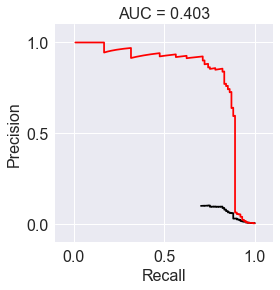

In [364]:
naive_bayes_pca = sklearn.naive_bayes.GaussianNB()
naive_bayes_pca.fit(features_train[columns_pca],class_train)
# estimator = sklearn.svm.SVC()
# # parameters = {'C':10**(py.linspace(-1,1,10))}
# parameters = {'C':[10**(0)]}
# scoring = 'average_precision'
# grid = sklearn.model_selection.GridSearchCV(estimator,parameters,scoring)
# grid.fit(features_train,class_train)
proba = naive_bayes_pca.predict_proba(features_test[columns_pca])
precision,recall,threshold = sklearn.metrics.precision_recall_curve(class_test,proba.T[1])
prc_gaussiannb = py.array([(x,y,z) for x,y,z in zip(precision,recall,threshold)]).T
metric = sklearn.metrics.average_precision_score(class_test,proba.T[1])
fig = py.figure()
ax = fig.add_subplot(111,aspect='equal')
ax.plot(prc_gaussiannb[1],prc_gaussiannb[0],'k-')
ax.plot(prc_logreg_all[1],prc_logreg_all[0],'r-')
ax.set_xlim(-0.1,1.1)
ax.set_ylim(-0.1,1.1)
ax.set_xticks([0,0.5,1.0])
ax.set_xticklabels([str(x) for x in ax.get_xticks()],fontsize=16)
ax.set_yticks([0,0.5,1.0])
ax.set_yticklabels([str(x) for x in ax.get_xticks()],fontsize=16)
ax.set_xlabel('Recall',fontsize=16)
ax.set_ylabel('Precision',fontsize=16)
ax.set_title('AUC = {:5.3f}'.format(metric),fontsize=16);

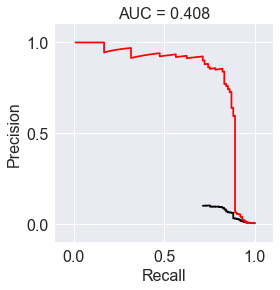

In [366]:
naive_bayes_pca = sklearn.naive_bayes.GaussianNB()
naive_bayes_pca.fit(features_train[columns_all],class_train)
proba = naive_bayes_pca.predict_proba(features_test[columns_all])
precision,recall,threshold = sklearn.metrics.precision_recall_curve(class_test,proba.T[1])
prc_gaussiannb = py.array([(x,y,z) for x,y,z in zip(precision,recall,threshold)]).T
metric = sklearn.metrics.average_precision_score(class_test,proba.T[1])
fig = py.figure()
ax = fig.add_subplot(111,aspect='equal')
ax.plot(prc_gaussiannb[1],prc_gaussiannb[0],'k-')
ax.plot(prc_logreg_all[1],prc_logreg_all[0],'r-')
ax.set_xlim(-0.1,1.1)
ax.set_ylim(-0.1,1.1)
ax.set_xticks([0,0.5,1.0])
ax.set_xticklabels([str(x) for x in ax.get_xticks()],fontsize=16)
ax.set_yticks([0,0.5,1.0])
ax.set_yticklabels([str(x) for x in ax.get_xticks()],fontsize=16)
ax.set_xlabel('Recall',fontsize=16)
ax.set_ylabel('Precision',fontsize=16)
ax.set_title('AUC = {:5.3f}'.format(metric),fontsize=16);

# Decision tree classifier

[[56837    24]
 [   19    82]]


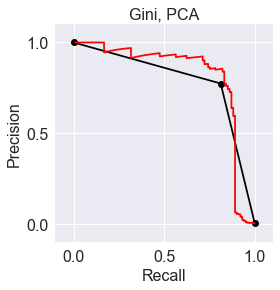

In [380]:
# Decision tree classifier, method: Gini
tree_gini_pca = sklearn.tree.DecisionTreeClassifier(criterion = 'gini')
tree_gini_pca.fit(features_train[columns_pca],class_train)
proba = tree_gini_pca.predict_proba(features_test[columns_pca])
precision,recall,threshold = sklearn.metrics.precision_recall_curve(class_test,proba.T[1])
prc_decisiontree = py.array([(x,y,z) for x,y,z in zip(precision,recall,threshold)]).T
metric = sklearn.metrics.average_precision_score(class_test,proba.T[1])
fig = py.figure()
ax = fig.add_subplot(111,aspect='equal')
ax.plot(recall,precision,'ko-')
ax.plot(prc_logreg_all[1],prc_logreg_all[0],'r-')
ax.set_xlim(-0.1,1.1)
ax.set_ylim(-0.1,1.1)
ax.set_xticks([0,0.5,1.0])
ax.set_xticklabels([str(x) for x in ax.get_xticks()],fontsize=16)
ax.set_yticks([0,0.5,1.0])
ax.set_yticklabels([str(x) for x in ax.get_xticks()],fontsize=16)
ax.set_xlabel('Recall',fontsize=16)
ax.set_ylabel('Precision',fontsize=16)
ax.set_title('Gini, PCA'.format(metric),fontsize=16);
print(sklearn.metrics.confusion_matrix(class_test,tree_gini_pca.predict(features_test[columns_pca])))

[[56834    27]
 [   19    82]]


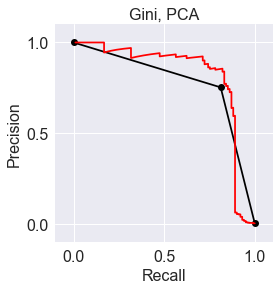

In [381]:
# Decision tree classifier, method: Entropy
tree_ent_pca = sklearn.tree.DecisionTreeClassifier(criterion = 'entropy')
tree_ent_pca.fit(features_train[columns_pca],class_train)
proba = tree_ent_pca.predict_proba(features_test[columns_pca])
precision,recall,threshold = sklearn.metrics.precision_recall_curve(class_test,proba.T[1])
prc_decisiontree = py.array([(x,y,z) for x,y,z in zip(precision,recall,threshold)]).T
metric = sklearn.metrics.average_precision_score(class_test,proba.T[1])
fig = py.figure()
ax = fig.add_subplot(111,aspect='equal')
ax.plot(recall,precision,'ko-')
ax.plot(prc_logreg_all[1],prc_logreg_all[0],'r-')
ax.set_xlim(-0.1,1.1)
ax.set_ylim(-0.1,1.1)
ax.set_xticks([0,0.5,1.0])
ax.set_xticklabels([str(x) for x in ax.get_xticks()],fontsize=16)
ax.set_yticks([0,0.5,1.0])
ax.set_yticklabels([str(x) for x in ax.get_xticks()],fontsize=16)
ax.set_xlabel('Recall',fontsize=16)
ax.set_ylabel('Precision',fontsize=16)
ax.set_title('Gini, PCA'.format(metric),fontsize=16);
print(sklearn.metrics.confusion_matrix(class_test,tree_ent_pca.predict(features_test[columns_pca])))

[[56839    22]
 [   21    80]]


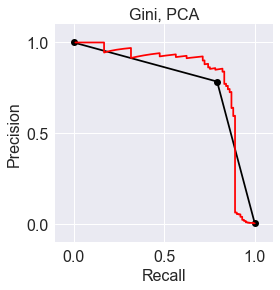

In [383]:
# Decision tree classifier, method: Gini
tree_gini_all = sklearn.tree.DecisionTreeClassifier(criterion = 'gini')
tree_gini_all.fit(features_train[columns_all],class_train)
proba = tree_gini_all.predict_proba(features_test[columns_all])
precision,recall,threshold = sklearn.metrics.precision_recall_curve(class_test,proba.T[1])
prc_decisiontree = py.array([(x,y,z) for x,y,z in zip(precision,recall,threshold)]).T
metric = sklearn.metrics.average_precision_score(class_test,proba.T[1])
fig = py.figure()
ax = fig.add_subplot(111,aspect='equal')
ax.plot(recall,precision,'ko-')
ax.plot(prc_logreg_all[1],prc_logreg_all[0],'r-')
ax.set_xlim(-0.1,1.1)
ax.set_ylim(-0.1,1.1)
ax.set_xticks([0,0.5,1.0])
ax.set_xticklabels([str(x) for x in ax.get_xticks()],fontsize=16)
ax.set_yticks([0,0.5,1.0])
ax.set_yticklabels([str(x) for x in ax.get_xticks()],fontsize=16)
ax.set_xlabel('Recall',fontsize=16)
ax.set_ylabel('Precision',fontsize=16)
ax.set_title('Gini, PCA'.format(metric),fontsize=16);
print(sklearn.metrics.confusion_matrix(class_test,tree_gini_all.predict(features_test[columns_all])))

[[56836    25]
 [   24    77]]


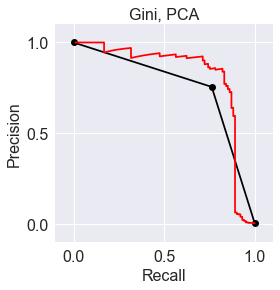

In [384]:
# Decision tree classifier, method: Entropy
tree_ent_all = sklearn.tree.DecisionTreeClassifier(criterion = 'entropy')
tree_ent_all.fit(features_train[columns_all],class_train)
proba = tree_ent_all.predict_proba(features_test[columns_all])
precision,recall,threshold = sklearn.metrics.precision_recall_curve(class_test,proba.T[1])
prc_decisiontree = py.array([(x,y,z) for x,y,z in zip(precision,recall,threshold)]).T
metric = sklearn.metrics.average_precision_score(class_test,proba.T[1])
fig = py.figure()
ax = fig.add_subplot(111,aspect='equal')
ax.plot(recall,precision,'ko-')
ax.plot(prc_logreg_all[1],prc_logreg_all[0],'r-')
ax.set_xlim(-0.1,1.1)
ax.set_ylim(-0.1,1.1)
ax.set_xticks([0,0.5,1.0])
ax.set_xticklabels([str(x) for x in ax.get_xticks()],fontsize=16)
ax.set_yticks([0,0.5,1.0])
ax.set_yticklabels([str(x) for x in ax.get_xticks()],fontsize=16)
ax.set_xlabel('Recall',fontsize=16)
ax.set_ylabel('Precision',fontsize=16)
ax.set_title('Gini, PCA'.format(metric),fontsize=16);
print(sklearn.metrics.confusion_matrix(class_test,tree_ent_all.predict(features_test[columns_all])))

Without any analysis, a given transaction has 0.18% chance of being fraudulent (or 1 in 564). With this decision tree, if it's flagged as fraudulent, it has 80.2% chance of being fraudulent. It it's flagged as valid, it has 0.036% chance of being fraudulent (or 1 in 20).

In [29]:
sklearn.tree.export_graphviz(
    estimator,
    feature_names=features_train.columns,
    class_names=['V','F'],  
    filled=True, rounded=True,special_characters=True                            
)

/Users/tiagobatalhao/anaconda/lib/python3.6/site-packages/sklearn/tree/export.py:386: DeprecationWarning: out_file can be set to None starting from 0.18. This will be the default in 0.20.
  DeprecationWarning)


## Search from decision trees


In [385]:
estimator = sklearn.tree.DecisionTreeClassifier()
parameters = {'criterion':['entropy','gini'],'class_weight':[None,'balanced'],'splitter':['best','random']}
# parameters = {'criterion':['entropy','gini']}
scoring = 'average_precision'
grid = sklearn.model_selection.GridSearchCV(estimator,parameters,scoring)
grid.fit(features_train[columns_all],class_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'criterion': ['entropy', 'gini'], 'class_weight': [None, 'balanced'], 'splitter': ['best', 'random']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='average_precision', verbose=0)

[[56836    25]
 [   24    77]]


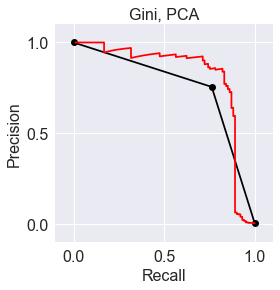

In [387]:
proba = grid.best_estimator_.predict_proba(features_test[columns_all])
precision,recall,threshold = sklearn.metrics.precision_recall_curve(class_test,proba.T[1])
prc_decisiontree = py.array([(x,y,z) for x,y,z in zip(precision,recall,threshold)]).T
metric = sklearn.metrics.average_precision_score(class_test,proba.T[1])
fig = py.figure()
ax = fig.add_subplot(111,aspect='equal')
ax.plot(recall,precision,'ko-')
ax.plot(prc_logreg_all[1],prc_logreg_all[0],'r-')
ax.set_xlim(-0.1,1.1)
ax.set_ylim(-0.1,1.1)
ax.set_xticks([0,0.5,1.0])
ax.set_xticklabels([str(x) for x in ax.get_xticks()],fontsize=16)
ax.set_yticks([0,0.5,1.0])
ax.set_yticklabels([str(x) for x in ax.get_xticks()],fontsize=16)
ax.set_xlabel('Recall',fontsize=16)
ax.set_ylabel('Precision',fontsize=16)
ax.set_title('Gini, PCA'.format(metric),fontsize=16);
print(sklearn.metrics.confusion_matrix(class_test,tree_ent_all.predict(features_test[columns_all])))

In [46]:
grid.estimator.fit(features_train,class_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

# Support vector machine (may take a long time)

In [396]:
model_linearsvc_pca = sklearn.svm.LinearSVC()
model_linearsvc_pca.fit(features_train[columns_pca],class_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [395]:
model_svc_pca = sklearn.svm.SVC()
model_svc_pca.fit(features_train[columns_pca],class_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [397]:
y_predict = model_linearsvc_pca.predict(features_test[columns_pca])
confusion_linearsvc = sklearn.metrics.confusion_matrix(class_test,y_predict)
y_predict = model_svc_pca.predict(features_test[columns_pca])
confusion_svc = sklearn.metrics.confusion_matrix(class_test,y_predict)

In [401]:
y_predict = model_linearsvc_pca.predict(features_test[columns_pca])
prc_linearsvc = sklearn.metrics.precision_recall_curve(class_test,y_predict)
y_predict = model_svc_pca.predict(features_test[columns_pca])
prc_svc = sklearn.metrics.precision_recall_curve(class_test,y_predict)

In [403]:
print(prc_svc)

(array([ 0.00177311,  0.91780822,  1.        ]), array([ 1.        ,  0.66336634,  0.        ]), array([0, 1]))


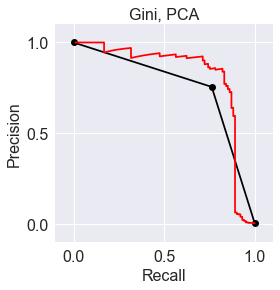

In [410]:
ax.plot([0,0],[1,1],'y--')
fig.canvas.draw()
fig

